In [1]:
from google.colab import drive 

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import re 
import string

import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/IMDB_Dataset.csv'

df = pd.read_csv(path)

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
category = pd.get_dummies(df.sentiment)
df = pd.concat([df, category], axis=1)
df = df.drop(columns='sentiment')
df

,review,negative,positive
0,One of the other reviewers has mentioned that ...,0,1
1,A wonderful little production. <br /><br />The...,0,1
2,I thought this was a wonderful way to spend ti...,0,1
3,Basically there's a family where a little boy ...,1,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0,1
...,...,...,...
49995,I thought this movie did a down right good job...,0,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",1,0
49997,I am a Catholic taught in parochial elementary...,1,0
49998,I'm going to have to disagree with the previou...,1,0


In [5]:
df_new = df[:2500]

df_new.shape

(2500, 3)

In [6]:
class TextPreprocessing():
  def case_folding(self, text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = text.lower() # ubah text menjadi huruf kecil
    text = text.strip() # menghapus wihte space pada awal kalimat
    text = re.sub(r"\d+", "", text) # menghapus angka yang tidak relevan
    text = text.translate(str.maketrans("","",string.punctuation)) # menghapus tanda baca
    return text

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end (self, epoch, logs={}):
    if (logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.85):
      keys = list(logs.keys())
      print("End epoch {} of training; got log keys: {}".format(epoch, keys))
      self.model.stop_training = True    

my_callbacks = myCallback()
text_preprocessing = TextPreprocessing()

In [7]:
df_new['review'] = df_new['review'].apply(text_preprocessing.case_folding).values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
df_new

,review,negative,positive
0,one of the other reviewers has mentioned that ...,0,1
1,a wonderful little production the filming tech...,0,1
2,i thought this was a wonderful way to spend ti...,0,1
3,basically theres a family where a little boy j...,1,0
4,petter matteis love in the time of money is a ...,0,1
...,...,...,...
2495,another great movie by costagavras its a great...,1,0
2496,though structured totally different from the b...,0,1
2497,handsome and dashing british airline pilot geo...,0,1
2498,this film breeches the fine line between satir...,1,0


In [9]:
review = df_new['review'].values
sentiment = df_new[['negative', 'positive']].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(review, sentiment, test_size=0.2)

In [11]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(X_train) 
tokenizer.fit_on_texts(X_test)
 
sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test)
 
padded_train = pad_sequences(sequence_train) 
padded_test = pad_sequences(sequence_test)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index), output_dim=16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.5)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [17]:
history = model.fit(padded_train, y_train, epochs=15, 
                    validation_data=(padded_test, y_test), callbacks=[my_callbacks])

Epoch 1/15
63/63 [==============================] - 102s 2s/step - loss: 0.6929 - accuracy: 0.5085 - val_loss: 0.7196 - val_accuracy: 0.5160
Epoch 2/15
63/63 [==============================] - 96s 2s/step - loss: 0.6880 - accuracy: 0.6275 - val_loss: 0.7974 - val_accuracy: 0.6880
Epoch 3/15
63/63 [==============================] - 96s 2s/step - loss: 0.5387 - accuracy: 0.7715 - val_loss: 0.5301 - val_accuracy: 0.7360
Epoch 4/15
63/63 [==============================] - 96s 2s/step - loss: 0.4273 - accuracy: 0.8220 - val_loss: 0.4614 - val_accuracy: 0.7780
Epoch 5/15
63/63 [==============================] - 96s 2s/step - loss: 0.3228 - accuracy: 0.8710 - val_loss: 0.4800 - val_accuracy: 0.7640
Epoch 6/15
63/63 [==============================] - 96s 2s/step - loss: 0.2953 - accuracy: 0.8900 - val_loss: 0.5161 - val_accuracy: 0.7820
Epoch 7/15
63/63 [==============================] - 96s 2s/step - loss: 0.2806 - accuracy: 0.9115 - val_loss: 0.4505 - val_accuracy: 0.8240
Epoch 8/15
63/63 [=

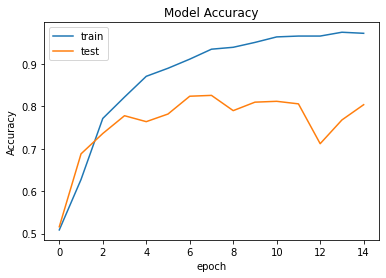

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

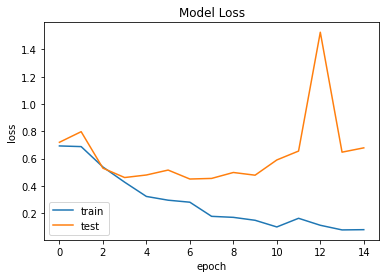

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()